# Predicting Wind Turbine Yield

Dataset is available here: https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data

...

Workflow:
- checking differences in output power between years: looking for year-to-year differences
- looking for a seasonal trend
- identifying correlations
- data cleaning

Methods:
- we can explore time-series based, but also other methods

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import ceil, floor
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from utils import remove_outliers_iqr

## Loading the data

In [3]:
feature_units = pd.read_csv("kaggle_dataset/feature_units.csv")
features = pd.read_csv("kaggle_dataset/features.csv", index_col="Timestamp")
features.index = pd.to_datetime(features.index)

power = pd.read_csv("kaggle_dataset/power.csv", index_col="Timestamp")
power.index = pd.to_datetime(power.index)

In [4]:
feature_units.shape, features.shape, power.shape

((77, 2), (154262, 76), (136730, 1))

In [8]:
features.index.min(), features.index.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2021-12-14 23:50:00'))

In [9]:
dataset_days = round(features.index.shape[0] / (6*24))
print(f"This dataset consists of {dataset_days} days")

This dataset consists of 1071 days


## Data Cleaning
Time series methods might have different handling of outliers, as we cannot simply drop them

In [10]:
nans_per_feature = features.isna().sum()
nans_per_feature.loc[nans_per_feature > 5000]

Gearbox_Oil_Temperature                              5176
Moment D Direction                                   5231
Temperature Heat Exchanger Converter Control Unit    5186
Pitch Offset-1 Asymmetric Load Controller            5023
Wind Deviation 10 seconds                            5132
Proxy Sensor_Degree-135                              5337
Pitch Demand Baseline_Degree                         5188
Blade-1 Set Value_Degree                             5506
Moment Q Filltered                                   5160
dtype: int64

In [11]:
# cols_to_drop = list(nans_per_feature[nans_per_feature > 5000].index)  # drop features which have more than 20% NaNs
# features.drop(columns=cols_to_drop, inplace=True)
# print("Dropping:", cols_to_drop)

# print("Before dropping rows with NaNs:", X.shape)
# X.dropna(inplace=True)
# y = y.loc[X.index]
# print("After dropping rows with NaNs:", X.shape)

### Checking dtypes
All features are numerical, some might be continuous, some might be discrete.

In [87]:
# features.select_dtypes(include='number').columns

In [86]:
sum(features.dtypes != float)

0

### Looking for duplicates

In [12]:
features.duplicated().sum()

0

### Looking for outliers

In [13]:
features_per_unit = feature_units.groupby('Unit').count().T
features_per_unit.columns

Index(['( )', '(%)', '()', '(Hz)', '(Nm)', '(V)', '(bar)', '(kNm)', '(kVAr)',
       '(kW)', '(mm)', '(mm/s²)', '(ms)', '(rpm)', '(°)', '(°C)'],
      dtype='object', name='Unit')

Temperatures in wind turbines do not reach 99999°C, these are missing values. After cleaning the temperatures seem realistic.

In [14]:
temperature_features = feature_units.loc[feature_units['Unit'] == '(°C)', 'Column'].to_list()
angle_features = feature_units.loc[feature_units['Unit'] == '(°)', 'Column'].to_list()

In [15]:
# Replaing 99999 in all features with a NaN
for col in features.columns:
    features[col].loc[features[col] == 99999] = np.nan

Some parts of the turbine on average are hotter than others.

(-10.0, 150.0)

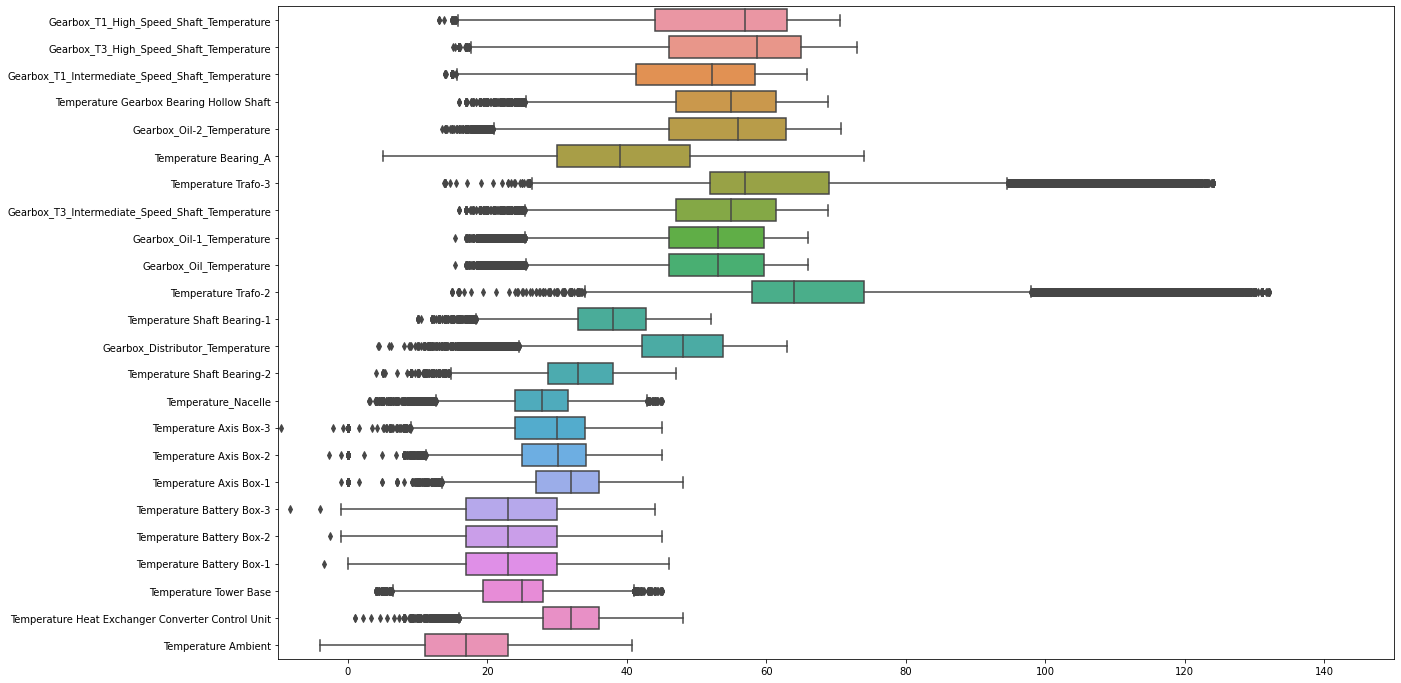

In [16]:
plt.figure(figsize=(20,12))
sns.boxplot(data=features[temperature_features], orient='h')
plt.xlim([-10, 150])

Angles should not be outside of the 0-360 degree range. What to do with negative angles?

In [33]:
# plt.figure(figsize=(16,8))
# sns.boxplot(data=features[angle_features], orient='h')
# plt.show()

In [18]:
n = floor(features[angle_features].min().min() / 360)

if n < 0:
    features[angle_features] += -n * 360
    features[angle_features] = features[angle_features] % 360
    
# (features[angle_features] % 360).describe()

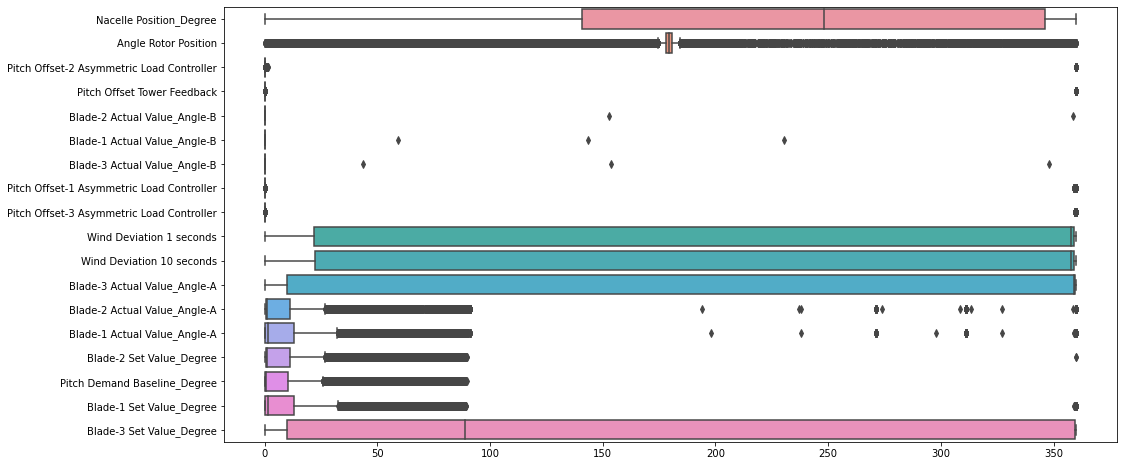

In [19]:
plt.figure(figsize=(16,8))
sns.boxplot(data=features[angle_features], orient='h')
plt.show()

### Removing outliers
When using time series models we cannot simply remove outliers, because they contain time information?

Can we simply replace extreme values with NaNs?

Warning: Dropping NaNs can actually remove important information!

In [20]:
# Remaining features
other = set(features.columns) - set(temperature_features + angle_features)

In [97]:
def find_outliers_iqr(X):
    for col in X.columns:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        if len(mask) > 0:
            print(col, len(mask))

In [98]:
find_outliers_iqr(features[other])

C:\Users\danie\AppData\Local\Temp\ipykernel_800\4260805748.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  find_outliers_iqr(features[other])


Tower Acceleration Lateral 3770
Hydraulic Prepressure 7135
Turbine State 28199
Torque Offset Tower Feedback 8581
Converter Control Unit Reactive Power 1127
Tower Acceleration Normal 5865
Converter Control Unit Voltage 3509
Proxy Sensor_Degree-225 785
External Power Limit 16
Line Frequency 3841
Torque 11998
Reactive Power 1276
Proxy Sensor_Degree-135 1306
Internal Power Limit 2253
N-set 1 27784
Nacelle Revolution 21
Moment Q Direction 4877
Moment D Direction 2267
Tower Accelaration Normal Raw 17472
Voltage A-N 177
Scope CH 4 24241
Proxy Sensor_Degree-45 719
Voltage C-N 266
Tower Accelaration Lateral Raw 22531
Voltage B-N 192
Operating State 27362
Tower Deflection 12428
Proxy Sensor_Degree-315 234
Moment Q Filltered 4848
State and Fault 27521
Moment D Filtered 2247


In [101]:
# Some columns contain only "outliers"! 

# print(features.isna().sum().sum())
# features = remove_outliers_iqr(features, other)
# print(features.isna().sum().sum())

437817
692665


## Exploratory Data Analysis

### Investigating correlations

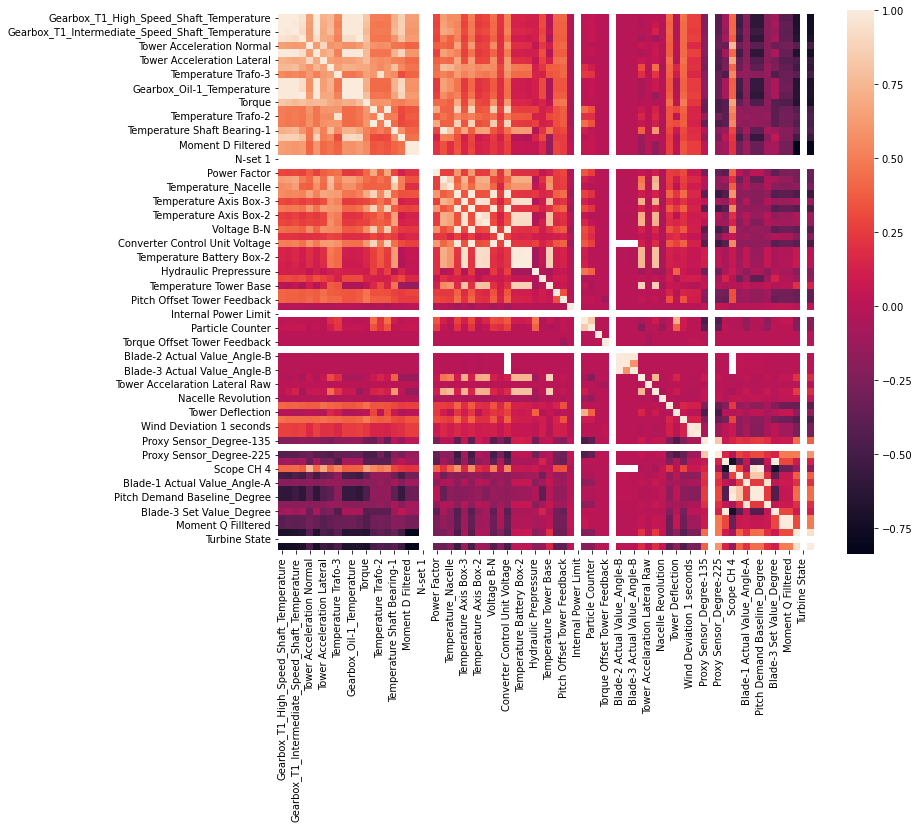

In [102]:
corr_matrix = features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, square=True)
plt.show()

### Analysing Conditions When Grid Frequency is far from 50Hz
What is the max margin around 50Hz tolerated by the grid? How does a wind turbine behave when there is no power in the grid?

In [69]:
grid_off = features.loc[(features['Line Frequency'] < 49) | (features['Line Frequency'] > 51)]
len(grid_off)

87

In [93]:
grid_off['Torque'].describe()

count     80.000000
mean     -13.319792
std       56.646422
min     -268.151459
25%        0.000000
50%        0.000000
75%        0.000000
max       98.957115
Name: Torque, dtype: float64

### Analysing Conditions when Active Power is Negative

In [24]:
power.isna().sum()

Power(kW)    0
dtype: int64

Why so many values of power are negative? Is it possible for a wind turbine to consume electricity?

In [25]:
power['Power(kW)'].min()

-48.5966682434082

In [26]:
power['Power(kW)'].loc[power['Power(kW)'] < 0].count()

24573

count    23705.000000
mean      -174.314340
std        224.428241
min      -1307.984985
25%       -311.864990
50%       -143.386673
75%          0.000000
max        474.959991
Name: Reactive Power, dtype: float64


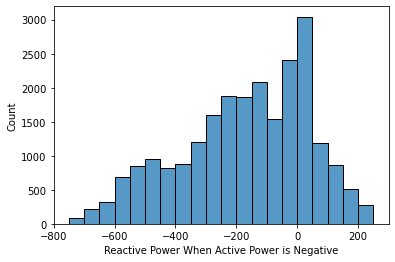

In [27]:
mask = power.loc[power['Power(kW)'] < 0].index
features_neg_power = features.loc[mask]
print(features_neg_power['Reactive Power'].describe())

sns.histplot(features_neg_power['Reactive Power'], binrange=(-750, 250), binwidth=50)
plt.xlabel("Reactive Power When Active Power is Negative")
plt.show()

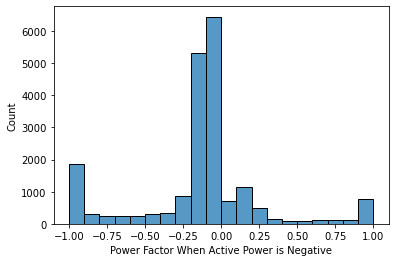

In [28]:
sns.histplot(features_neg_power['Power Factor'], binrange=(-1, 1), binwidth=0.1)
plt.xlabel("Power Factor When Active Power is Negative")
plt.show()

<AxesSubplot:xlabel='Torque', ylabel='Count'>

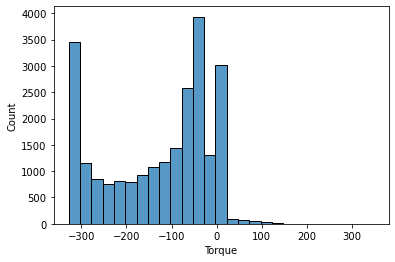

In [29]:
sns.histplot(features_neg_power['Torque'], binwidth=25)

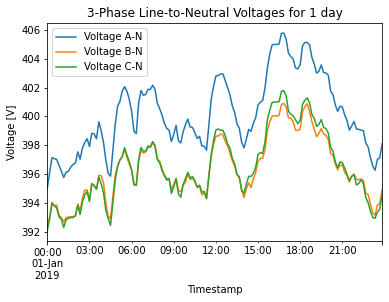

In [30]:
features[['Voltage A-N', 'Voltage B-N', 'Voltage C-N']].iloc[0:6*24].plot()
plt.title("3-Phase Line-to-Neutral Voltages for 1 day")
plt.ylabel("Voltage [V]")
plt.show()

## Time Series Decomposition
Wind speed / power time series is expected to have seasonality, as wind speeds tend to be higher in winter. 

Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary:
- constant mean
- constant variance
- autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.

https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

In [31]:
# # Test for stationarity
# y = power['Power(kW)']
# adf_test = adfuller(y, regression='c')
# print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
#       .format(adf_test[0], adf_test[1], adf_test[2]))
# for key, value in adf_test[4].items():
#     print('Critical Value ({}): {:.6f}'.format(key, value))

In [103]:
power.resample("Y")['Power(kW)'].sum()

Timestamp
2019-12-31    5.852937e+07
2020-12-31    6.182047e+07
2021-12-31    3.532497e+07
Freq: A-DEC, Name: Power(kW), dtype: float64

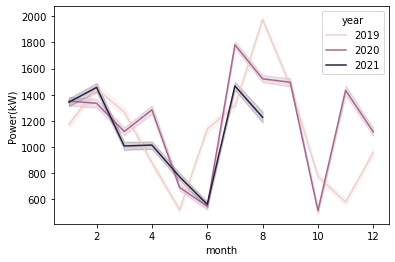

In [104]:
power['month'] = power.index.month
power['year'] = power.index.year

sns.lineplot(data=power, 
             x='month', 
             y='Power(kW)', 
             hue='year', 
             legend='full')
plt.show()

<AxesSubplot:xlabel='Timestamp'>

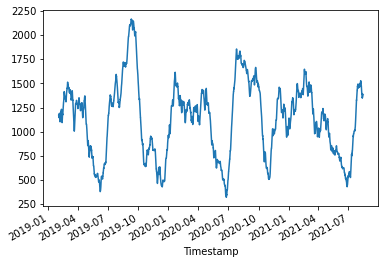

In [129]:
window_size = 31 * 24 *6
moving_avg = power['Power(kW)'].rolling(window_size).mean()

moving_avg.plot()

<AxesSubplot:xlabel='Timestamp'>

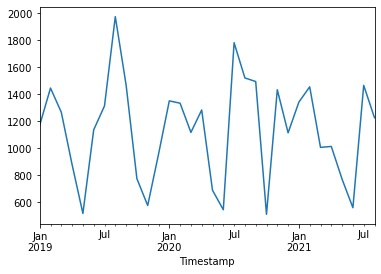

In [107]:
power['Power(kW)'].resample("M").mean().plot()

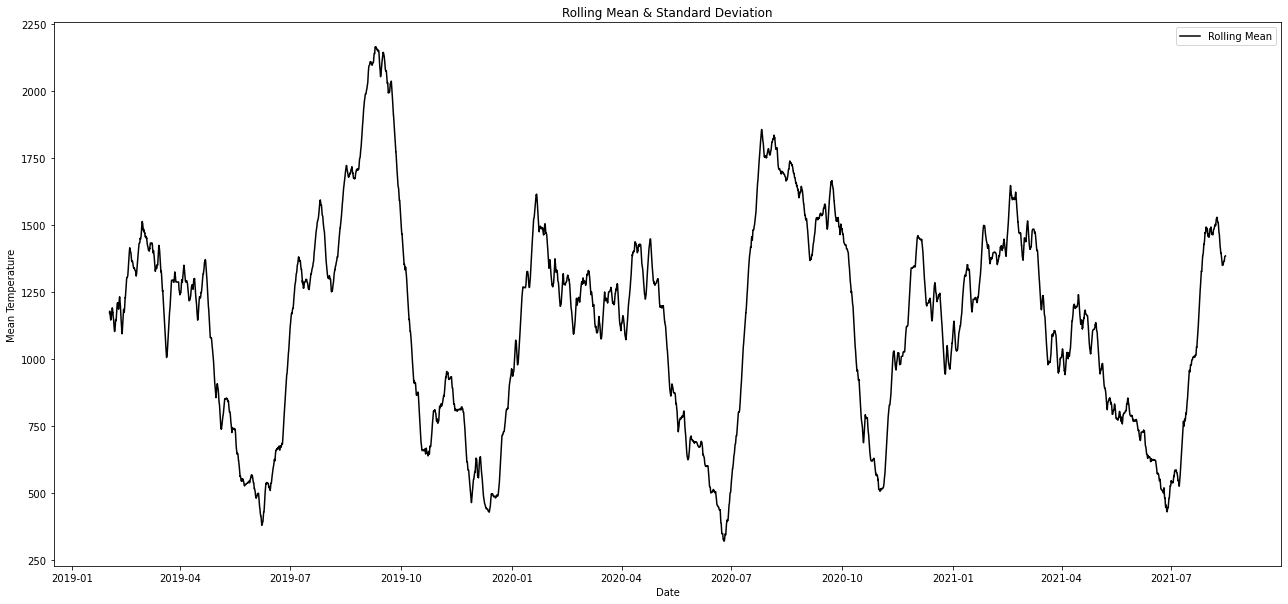

In [112]:
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(window=6*24*31).mean()
    rolstd = ts.rolling(window=6*24*31).std()
    plt.figure(figsize=(22,10))   
#     orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
#     std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
# check_mean_std(power.loc[power['year'] == 2019, 'Power(kW)'])
check_mean_std(power['Power(kW)'])

Mean (black) is not constant, variance (green) is also not constant --> not stationary?

In ADF the test statistic is below the critical value -> stationary?

Time series is definitely not stationary (based on constant mean and variance requirement).

In [ ]:
check_adfuller(power.loc[power['year'] == 2019, 'Power(kW)'])

In [ ]:
check_adfuller(power['Power(kW)'])

- As we mentioned before, there are 2 reasons behind non-stationarity of time series
    - Trend: varying mean over time. We need constant mean for stationary of time series.
    - Seasonality: variations at specific time. We need constant variations for stationary of time series.
- First solve trend(constant mean) problem
    - Most popular method is moving average.
        - Moving average: We have window that take the average over the past 'n' sample. 'n' is window size.
        
There should be no trend, as the power output is not increasing or decreasing over time. Perhaps if we had data over a full lifetime of a turbine we could see decay of its performance over time. 

There should be seasonality, as wind speeds change with seasons, they often are higher in winter. PV and wind can sometimes be complementary.

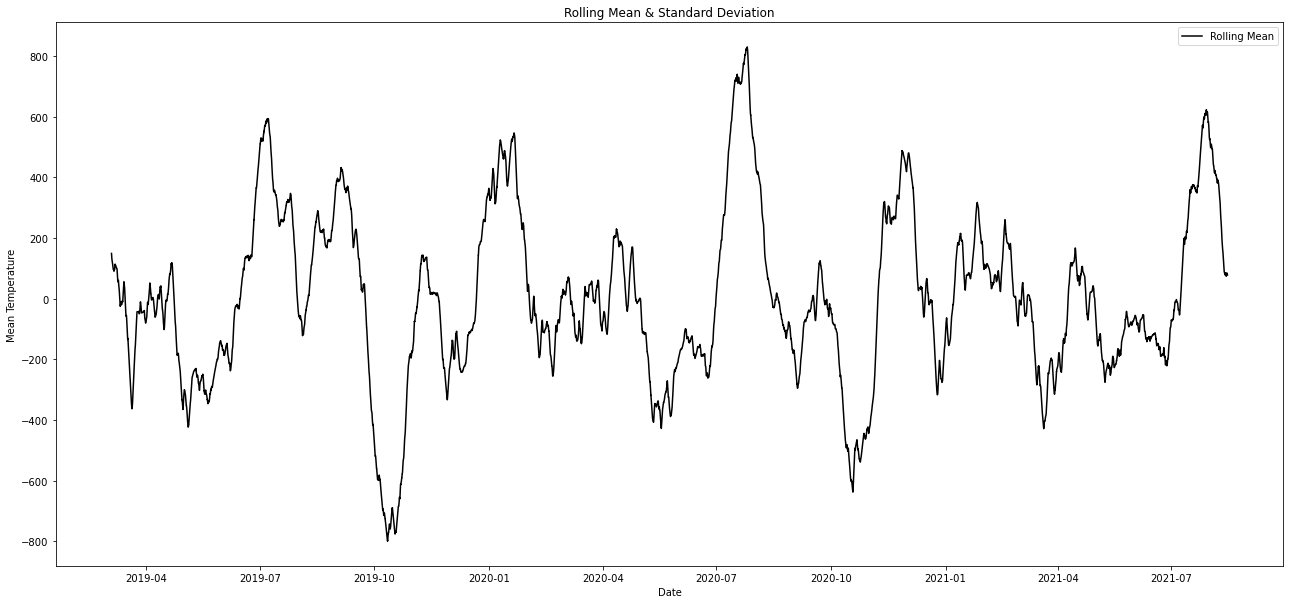

In [128]:
ts_moving_avg_diff = power['Power(kW)'] - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 6 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
# check_adfuller(ts_moving_avg_diff.MeanTemp)

- Seasonality: describes the periodic signal in your time series.
- Trend: describes whether the time series is decreasing, constant, or increasing over time.
- Noise: describes what remains behind the separation of seasonality and trend from the time series. In other words, it’s the variability in the data that cannot be explained by the model.

https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2

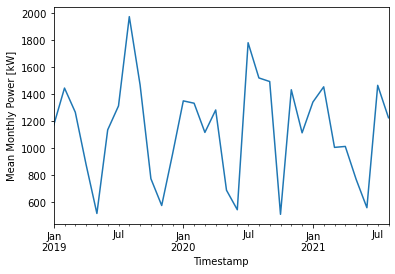

In [130]:
power_monthly = power['Power(kW)'].resample('M').mean()

power_monthly.plot()
plt.ylabel("Mean Monthly Power [kW]")
plt.show()

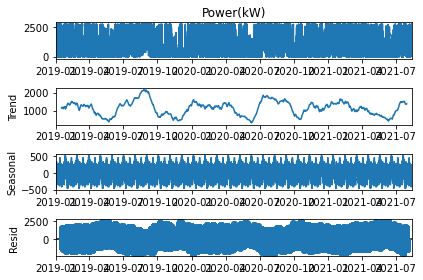

In [166]:
result = seasonal_decompose(power['Power(kW)'], model='additive', period=31*24*6)  # power_monthly
result.plot()
plt.show()

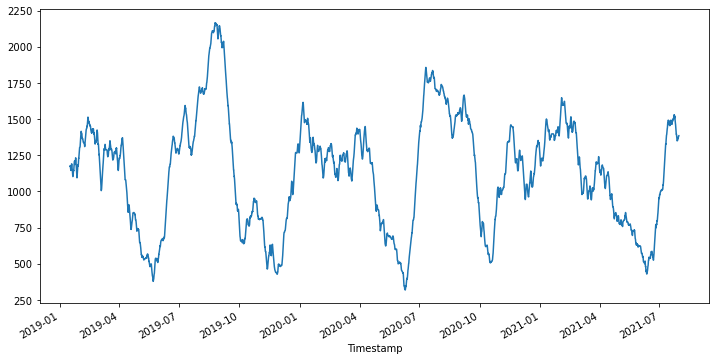

In [167]:
plt.figure(figsize=(12, 6))
result.trend.plot()
plt.show()

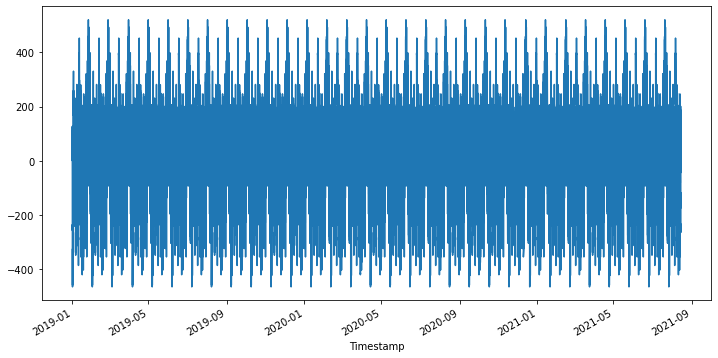

In [154]:
plt.figure(figsize=(12, 6))
result.seasonal.plot()
plt.show()

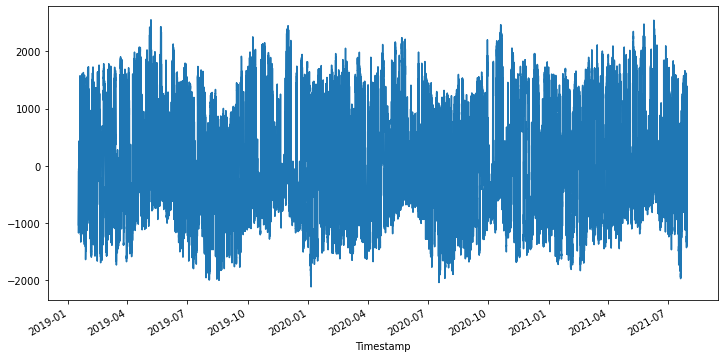

In [153]:
plt.figure(figsize=(12, 6))
result.resid.plot()
plt.show()

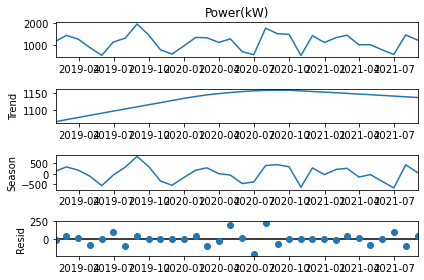

In [163]:
stl = STL(power_monthly, period=12)
res = stl.fit()
res.plot()
plt.show()

## Feature Engineering

In [ ]:
# Month
# Year

## Modeling
Exploring timeseries methods, as well as regression methods with lagged features.